In the previous notebook, we discussed an overview of what deep learning is and why you might want to use it for cognitive modeling. In the present notebook, we will review some acoustic aspects of speech and then construct a model of phoneme recognition that we will use to investigate the recognition of morphologically complex words and how the dscriminability of segments changes over time.

Please note that some simplifications are made for the purposes of the workshop.

1. **Phonemes here are being used in the engineering/speech recognition sense**, which is only semi-related to how phonemes are discussed and used in linguistics. Here, they are used to refer to acoustically similar segments of speech, such as that /s/ will be acoustically similar in many of the instances in which it is encountered. The motivation for using phonemes is that a wide variety of deep neural networks that work with speech are designed to recognize phonemes.

2. **We are not using any sort of holdout data for testing or validation of the model.** Best practices for deep learning modeling are to have some data held out to assess the model on items it hasn't seen. Given the timeframe we are working with, we will eschew validating the model that we are training against novel data. This is not unlike using statistical regression models for psycholinguistic experiments, either, where it is typical to use all of the collected data for analysis.

3. **Some bits of code that are used for loading and formatting data will be placed inside a `Julia` script that is called from within this notebook.** The code is available for you to peruse in the GitHub repository that the present notebook is part of, but the code will not be discussed in detail during the course of this workshop. The code otherwise distracts from the purposes of setting up and interpreting a deep learning model.

# Speech acoustics

* The speech signal is a time-series acoustic signal
    * It unfolds over time, meaning there is an inherent sequential order to segments of it
    * Previous sections of the signal can predict future sections
* We can analyze the speech signal as being composed of many different sound frequencies
    * E.g., /s/ contains a large amount of energy at around 6000 Hz

# Speech features in deep learning

* Neural networks aren't trained with the entire frequency spectrum of speech as input data
    * It would take too much memory
    * There would be more numbers to crunch, so they would run slower
    * We know humans, who speech is targeted to, perceive frequencies in a more log scale than linear scale, and not all frequencies are necessarily important (e.g., certain resonant frequencies are crucial in vowels, while random noise is not)
* Instead, neural networks are trained with more compact representations of speech
* Historically, a set of features known as Mel frequency cepstral coefficients (MFCCs) have frequently been used, which we will also be using
    * They represent a transform on the frequency information
    * Usually calculate derivatives to represent their change over time in the features
    * Compact description of the speech signal
    * Mathematically related to audio compression algorithms such as MP3
* Other options that have been used are Mel filterbanks, linear predictive coding (LPC) coefficients, perceptual linear predcitive coding (PLPC) coefficients, and filterbanks the network is foced to learn
* MFCCs (and other features) are calculated over small segments of speech over time
    * Commonly, calculated to describe 25 ms windows of speech with 10 ms between each window
* The features have already been calculated for the present workshop, and the resultant data will be loaded in

Let's get the environment set up.

In [7]:
using Flux # Deep learning library
using Flux: crossentropy, @epochs
using Flux.Tracker: data
using ProgressBars # Displays progress of training
using Statistics # Contains functions like `mean`
using Plots # Used for visualizing data
using Loess # Used to smooth data for plotting purposes
using Revise

includet("utils.jl") # This is the file containing the helper code for data loading and manipulation
const BATCH_SIZE = 50 # Specify the batch size for training the models
const N_EPOCHS = 5 # number of epochs for which to train the network

5

# What we're going to model

Keeping in mind that this is a conference on morphological processing, we're going to examine whether morphologically complex words get easier or harder to discriminate as the speech signal unfolds. Note that this will be more of a proof-of-concept model than a ready-to-publish model. Let's lay out some considerations.

1. We're going to be using speech data as input. Because of the sequential nature of speech, it is more ecological for a cognitive model to be able to capture the sequential nature. As such, some sort of recurrent layer would make sense to use.

2. For our outputs, we're going to be using phonemes. This requires us to have phonetically aligned speech data, and luckily the MALD data set is phonetically aligned.

3. This is a classification problem (classifying segments of audio as particular phonemes), as opposed to a regression problem, so we will have multiple outputs.

4. Classification problems frequently optimize categorical cross-entropy, which is a measure of how well the probability distribution the network output matches the target distribution. It is also an indication of how discriminable a segment of audio is (and by correlate, how discriminable that word is at that time, on the basis of phonetic information).

5. Because the goal is examine discriminability of words as the speech signal unfolds, we should plan to visualize the categorical cross-entropy and see how it changes across phonemes/segments.

Let's set up the model.

In [3]:
model = Chain(LSTM(39, 70),
          LSTM(70, 50),
          Dense(50, 61),
          softmax
         )

Chain(Recur(LSTMCell(39, 70)), Recur(LSTMCell(70, 50)), Dense(50, 61), softmax)

Using the `Chain()` function allows us to chain a series of functions together. We can consider the layers as functions, and the data flows through them. The first layer is an LSTM layer with `39` input features and `70` output features. By default, an `LSTM` layer uses a hyperbolic tangent (tanh) activation function that will scale its output between `-1` and `1`. The second layer is another LSTM layer with `70` input features (coming from the first layer) and `50` output features. The final layer is a dense layer with `50` input features from the second layer, and `61` output features, representing the `61` phonemes that we are classifying between.

The two LSTM layers are serving to learn the temporal patterns of the speech data, and the dense layer linearly maps from the LSTM layers to the output. The output is passed into a `softmax` layer, which will convert it to a probability distribution (such that all possibilities sum to `1`).

Let's now define our loss function.

In [4]:
losses = []

function loss(x, y)
  global losses
  yhat = model.(x)
  l = crossentropy.(yhat, y) |> sum
  push!(losses, data(l) / length(yhat))
  Flux.reset!(model)
  return l
end

loss (generic function with 1 method)

The `loss` function takes in `x` the input sequences and `y` the target phonemes. The loss is calculated by passing `x` into the model to calculate `yhat`. The loss is then the sum of the cross entropy between `yhat` and `y`. Optimzing this loss function brings the models classification results closer and closer to the target classification.

There is a bit of code that performs cleanup and performance monitoring. The `losses` variable stores all the losses over an epoch of training for evaluation purposes. Additionally, because the LSTM layers have a sort of memory, they need to be reset once the sequence they are processing has ended; otherwise, they will continue to process the next sequence as though it was part of the first.

Let's now set up and run the training routine.

In [9]:
opt = ADAM()

p = params(model)

Xs, Ys = loadData()

println("training")
@epochs N_EPOCHS begin
      
  global losses
  
  d = prepData(Xs, Ys)
  
  Flux.train!(loss, p, ProgressBar(d), opt)
  println("loss:\t", mean(losses))
  println()
  losses = []
end

Loading data


59.83%

100.00%┣████████████████████████████████████████████████████▉┫ 10000/10000 00:08<00:00, 1208.29 it/s]
training
100.00%┣███████████████████████████████████████████████████████████▉┫ 200/200 00:32<00:00, 6.15 it/s]┣████▍                                                          ┫ 14/200 00:03<00:37, 5.09 it/s]┣██████████████████▎                                           ┫ 59/200 00:10<00:23, 6.00 it/s]▋                               ┫ 99/200 00:16<00:17, 5.98 it/s]▍                   ┫ 136/200 00:22<00:11, 6.05 it/s]┣████████████████████████████████████████████████████▏        ┫ 171/200 00:28<00:05, 6.08 it/s]
loss:	1.0783119722860366

100.00%┣███████████████████████████████████████████████████████████▉┫ 200/200 00:34<00:00, 5.89 it/s]┫ 3/200 00:01<01:18, 2.52 it/s]┣████████████████████████████▏                                 ┫ 91/200 00:15<00:19, 5.84 it/s]▋           ┫ 163/200 00:27<00:06, 5.92 it/s]┣███████████████████████████████████████████████████████████▊ ┫ 196/200 00:33<00:01, 5

An optimizer object is created using the `ADAM()` function. The Adam optimizer tracks how much each individual component of the network contributes to its performance and strengthens or weakens connections accordingly. Additionally, it learns how sensitive the weights should be to adustments. In a sense, once the network is performing reasonably well, you don't want to make large adjustments to the weights because it may cause the model to perform much worse than it was before.

Next, the trainable parameters are gathered, then the data are loaded. We creat a collection of the indices in the data so that we can change the training order. It is not strictly necessary to shuffle the order of the training data, but it is good modeling practice becuase it often causes the model to converge to a good state faster than otherwise.

Finally, the training cycle begins. We are training it for `5` epochs. At the start of each epoch, we create a variable that will create small batches of data to train on and places them into a list where each element is a pair of inputs and target outputs.

The epoch's actual training occurs in the `train!()` function. The training make take a bit of time. The overall average training loss for each phoneme classificaiton is printed at the end of each epoch.

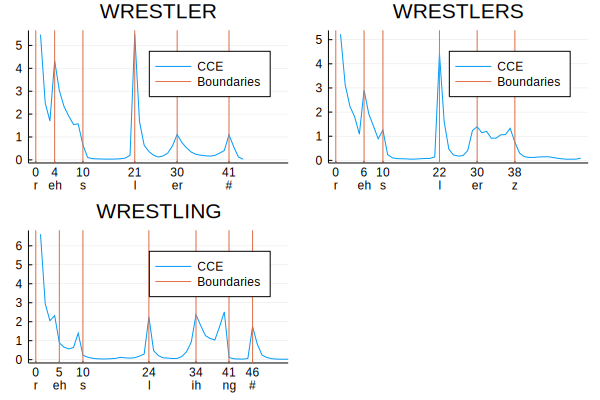

In [20]:
wrestler_cce = calculateCrossEntropy("WRESTLER", model)
wrestler_t = Float64.(collect(1:length(wrestler_cce)))
wrestler_b = findBoundaries("WRESTLER")

wrestlers_cce = calculateCrossEntropy("WRESTLERS", model)
wrestlers_t = Float64.(collect(1:length(wrestlers_cce)))
wrestlers_b = findBoundaries("WRESTLERS")

wrestling_cce = calculateCrossEntropy("WRESTLING", model)
wrestling_t = Float64.(collect(1:length(wrestling_cce)))
wrestling_b = findBoundaries("WRESTLING")

lengths = [length(wrestler_t), length(wrestlers_t), length(wrestlers_b)]

wrestler = plot(wrestler_t, wrestler_cce, xlim=[0, maximum(lengths)], lab="CCE", title="WRESTLER")
wrestler_ticks = makeTicks(wrestler_b, transcribe("WRESTLER"))
wrestler = vline!(wrestler_b, lab="Boundaries", xticks=wrestler_ticks)

wrestlers = plot(wrestlers_t, wrestlers_cce, xlim=[0, maximum(lengths)], lab="CCE", title="WRESTLERS")
wrestlers_ticks = makeTicks(wrestlers_b, transcribe("WRESTLERS"))
wrestlers = vline!(wrestlers_b, lab="Boundaries", xticks=wrestlers_ticks)

wrestling = plot(wrestling_t, wrestling_cce, xlim=[0, maximum(lengths)], lab="CCE", title="WRESTLING")
wrestling_ticks = makeTicks(wrestling_b, transcribe("WRESTLING"))
wrestling = vline!(wrestling_b, lab="Boundaries", xticks=wrestling_ticks)

plot(wrestler, wrestlers, wrestling, layout=3)

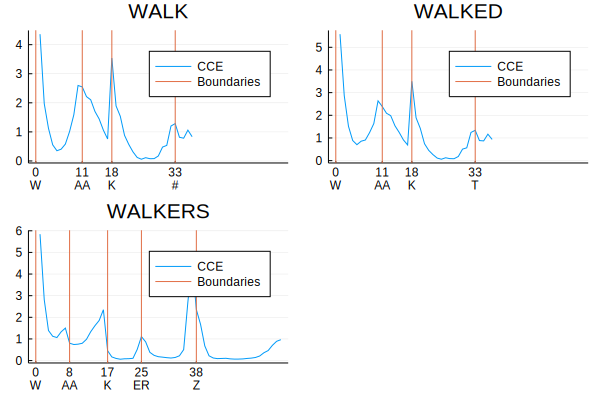

In [29]:
walk_cce = calculateCrossEntropy("WALK", model)

walk_t = Float64.(collect(1:length(walk_cce)))
walk_b = findBoundaries("WALK")

walked_cce = calculateCrossEntropy("WALK", model)
walked_t = Float64.(collect(1:length(walked_cce)))
walked_b = findBoundaries("WALK")

walkers_cce = calculateCrossEntropy("WALKERS", model)
walkers_t = Float64.(collect(1:length(walkers_cce)))
walkers_b = findBoundaries("WALKERS")

lengths = [length(walk_t), length(walked_t), length(walkers_t)]

walk = plot(walk_t, walk_cce, xlim=[0, maximum(lengths)], lab="CCE", title="WALK")
walk_ticks = makeTicks(walk_b, transcribe("WALK"))
walk = vline!(walk_b, lab="Boundaries", xticks=walk_ticks)

walked = plot(walked_t, walked_cce, xlim=[0, maximum(lengths)], lab="CCE", title="WALKED")
walked_ticks = makeTicks(walked_b, transcribe("WALKED"))
walked = vline!(walked_b, lab="Boundaries", xticks=walked_ticks)

walkers = plot(walkers_t, walkers_cce, xlim=[0, maximum(lengths)], lab="CCE", title="WALKERS")
walkers_ticks = makeTicks(walkers_b, transcribe("WALKERS"))
walkers = vline!(walkers_b, lab="Boundaries", xticks=walkers_ticks)

plot(walk, walked, walkers, layout=3)

# References